In [0]:
#dbutils.fs.rm("/FileStore/tables/test_features.csv")

# MIE-1628 Final Project Starter Code

## 1. Import libraries

In [0]:
from pyspark.sql import Row
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, mean as _mean, stddev as _stddev, log, log10
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit


from pyspark.sql.functions import udf, expr, concat, col, count, when, isnan

spark = SparkSession(sc)
sqlc=SQLContext(sc)

## 2. Import data

In [0]:
train_features = sqlc.read.csv('/FileStore/tables/final_project/train_features.csv', header = True,inferSchema=True)
train_targets_scored = sqlc.read.csv('/FileStore/tables/final_project/train_targets_scored.csv', header = True,inferSchema=True)

test_features = sqlc.read.csv('/FileStore/tables/final_project/test_features.csv', header = True,inferSchema=True)

In [0]:
# check all columns and their types
train_features.printSchema()

root
-- sig_id: string (nullable = true)
-- cp_type: string (nullable = true)
-- cp_time: integer (nullable = true)
-- cp_dose: string (nullable = true)
-- g-0: double (nullable = true)
-- g-1: double (nullable = true)
-- g-2: double (nullable = true)
-- g-3: double (nullable = true)
-- g-4: double (nullable = true)
-- g-5: double (nullable = true)
-- g-6: double (nullable = true)
-- g-7: double (nullable = true)
-- g-8: double (nullable = true)
-- g-9: double (nullable = true)
-- g-10: double (nullable = true)
-- g-11: double (nullable = true)
-- g-12: double (nullable = true)
-- g-13: double (nullable = true)
-- g-14: double (nullable = true)
-- g-15: double (nullable = true)
-- g-16: double (nullable = true)
-- g-17: double (nullable = true)
-- g-18: double (nullable = true)
-- g-19: double (nullable = true)
-- g-20: double (nullable = true)
-- g-21: double (nullable = true)
-- g-22: double (nullable = true)
-- g-23: double (nullable = true)
-- g-24: double (nullable = true)
-- g-25: double (nullable = true)
-- g-26: double (nullable = true)
-- g-27: double (nullable = true)
-- g-28: double (nullable = true)
-- g-29: double (nullable = true)
-- g-30: double (nullable = true)
-- g-31: double (nullable = true)
-- g-32: double (nullable = true)
-- g-33: double (nullable = true)
-- g-34: double (nullable = true)
-- g-35: double (nullable = true)
-- g-36: double (nullable = true)
-- g-37: double (nullable = true)
-- g-38: double (nullable = true)
-- g-39: double (nullable = true)
-- g-40: double (nullable = true)
-- g-41: double (nullable = true)
-- g-42: double (nullable = true)
-- g-43: double (nullable = true)
-- g-44: double (nullable = true)
-- g-45: double (nullable = true)
-- g-46: double (nullable = true)
-- g-47: double (nullable = true)
-- g-48: double (nullable = true)
-- g-49: double (nullable = true)
-- g-50: double (nullable = true)
-- g-51: double (nullable = true)
-- g-52: double (nullable = true)
-- g-53: double (nullable = true)
-- g-54: double (nullable = true)
-- g-55: double (nullable = true)
-- g-56: double (nullable = true)
-- g-57: double (nullable = true)
-- g-58: double (nullable = true)
-- g-59: double (nullable = true)
-- g-60: double (nullable = true)
-- g-61: double (nullable = true)
-- g-62: double (nullable = true)
-- g-63: double (nullable = true)
-- g-64: double (nullable = true)
-- g-65: double (nullable = true)
-- g-66: double (nullable = true)
-- g-67: double (nullable = true)
-- g-68: double (nullable = true)
-- g-69: double (nullable = true)
-- g-70: double (nullable = true)
-- g-71: double (nullable = true)
-- g-72: double (nullable = true)
-- g-73: double (nullable = true)
-- g-74: double (nullable = true)
-- g-75: double (nullable = true)
-- g-76: double (nullable = true)
-- g-77: double (nullable = true)
-- g-78: double (nullable = true)
-- g-79: double (nullable = true)
-- g-80: double (nullable = true)
-- g-81: double (nullable = true)
-- g-82: double (nullable = true)
-- g-83: double (nullable = true)
-- g-84: double (nullable = true)
-- g-85: double (nullable = true)
-- g-86: double (nullable = true)
-- g-87: double (nullable = true)
-- g-88: double (nullable = true)
-- g-89: double (nullable = true)
-- g-90: double (nullable = true)
-- g-91: double (nullable = true)
-- g-92: double (nullable = true)
-- g-93: double (nullable = true)
-- g-94: double (nullable = true)
-- g-95: double (nullable = true)
-- g-96: double (nullable = true)
-- g-97: double (nullable = true)
-- g-98: double (nullable = true)
-- g-99: double (nullable = true)
-- g-100: double (nullable = true)
-- g-101: double (nullable = true)
-- g-102: double (nullable = true)
-- g-103: double (nullable = true)
-- g-104: double (nullable = true)
-- g-105: double (nullable = true)
-- g-106: double (nullable = true)
-- g-107: double (nullable = true)
-- g-108: double (nullable = true)
-- g-109: double (nullable = true)
-- g-110: double (nullable = true)
-- g-111: double (nullable = true)
-- g-112: double (nullable = true)
--

## 3. Check Missing Values

In [0]:
# for each feature, compute the total number of missing values
missing_v = train_features.select([count(when(isnan(col), col)).alias(col) for col in train_features.columns])

In [0]:
# filter out features without missing values
def f(x):
  l = len(x)
  missing_value_index = []
  for i in range(l):
    if x[i] != 0:
      missing_value_index.append(i)
  return missing_value_index

a = missing_v.rdd.map(tuple).map(f)
a.take(1)

Out[6]: [[]]

There is no missing values in the data

## 4. EDA

sig_id

In [0]:
# check if sig_id is unique
train_features.select("sig_id").distinct().count() == train_features.count()

Out[3]: True

cp_type

In [0]:
# check cp_type unique values
train_features.select("cp_type").distinct().show()

# get the value counts for each cp_type
trt_cp = train_features.select("cp_type").where(train_features.cp_type == 'trt_cp').count()
ctl_vehicle = train_features.select("cp_type").where(train_features.cp_type == 'ctl_vehicle').count()

+-----------+
 cp_type|
+-----------+
 trt_cp|
ctl_vehicle|
+-----------+

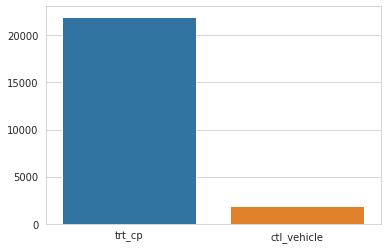

In [0]:
import seaborn as sns
sns.set_style('whitegrid')

# get distribution of cp_type
sns.barplot(['trt_cp', 'ctl_vehicle'], [trt_cp, ctl_vehicle])
sns.set_title("cp_type distribution")

In [0]:
# drop ctl_vehicle, then drop cp_type
train_features = train_features.filter(train_features.cp_type != 'ctl_vehicle').drop('cp_type')
test_features = test_features.filter(test_features.cp_type != 'ctl_vehicle').drop('cp_type')

cp_time

In [0]:
# check cp_time unique values
train_features.groupBy(train_features.cp_time).count().orderBy('count').show()

# get the value counts for each cp_time
time_value_counts = train_features.groupBy(train_features.cp_time).count().orderBy('count').\
  selectExpr("cp_time as cp_time", "count as _count").collect()

time_values = [int(row.cp_time) for row in time_value_counts]
time_counts = [int(row._count) for row in time_value_counts]

+-------+-----+
cp_time|count|
+-------+-----+
 24| 7166|
 72| 7180|
 48| 7602|
+-------+-----+

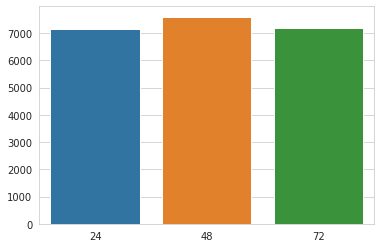

In [0]:
# get distribution of cp_time
sns.barplot(time_values, time_counts)
sns.set_title("cp_type distribution")

cp_dose

In [0]:
# check cp_dose unique values
train_features.groupBy(train_features.cp_dose).count().orderBy('count').show()

# get the value counts for each cp_dose
dose_value_counts = train_features.groupBy(train_features.cp_dose).count().orderBy('count').\
  selectExpr("cp_dose as cp_dose", "count as _count").collect()

dose_values = [row.cp_dose for row in dose_value_counts]
dose_counts = [int(row._count) for row in dose_value_counts]

+-------+-----+
cp_dose|count|
+-------+-----+
 D2|10752|
 D1|11196|
+-------+-----+

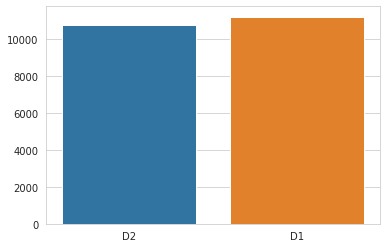

In [0]:
# get distribution of cp_dose
sns.barplot(dose_values, dose_counts)
sns.set_title("cp_dose distribution")

In [0]:
# get dummies for cp_time and cp_dose
cp_time_expr = [F.when(F.col("cp_time") == ty, 1).otherwise(0).alias("cp_time_" + str(ty)) for ty in time_values]
cp_dose_expr = [F.when(F.col("cp_dose") == ty, 1).otherwise(0).alias("cp_dose_" + ty) for ty in dose_values]

train_cleaned = train_features.select('*', *cp_time_expr+cp_dose_expr).drop('cp_time', 'cp_dose')
test_cleaned = test_features.select('*', *cp_time_expr+cp_dose_expr).drop('cp_time', 'cp_dose')

## 5. PCA

In [0]:
# from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
# from pyspark.ml.linalg import Vectors

# # union train and test df
# df_train_test = train_cleaned.union(test_cleaned)

# # get  gene expression and cell viability feature name lists
# columns = train_cleaned.columns
# g_col = [col for col in columns if col[:2] == 'g-']
# c_col = [col for col in columns if col[:2] == 'c-']

# # initial Vector Assembler
# g_assembler = VectorAssembler(
#     inputCols = g_col, outputCol = 'gene_features')
# c_assembler = VectorAssembler(
#     inputCols = c_col, outputCol = 'cell_features')

# # transform gene and cell data
# g_features = g_assembler.transform(df_train_test)
# gc_features = c_assembler.transform(g_features)

# # standardize the data
# g_scaler = StandardScaler(
#     inputCol = 'gene_features', 
#     outputCol = 'gene_scaledFeatures',
#     withMean = True,
#     withStd = True
# ).fit(gc_features)

# c_scaler = StandardScaler(
#     inputCol = 'cell_features', 
#     outputCol = 'cell_scaledFeatures',
#     withMean = True,
#     withStd = True
# ).fit(gc_features)

# # when we transform the dataframe, the old
# # feature will still remain in it
# g_scaledFeatures = g_scaler.transform(gc_features)
# gc_scaledFeatures = c_scaler.transform(g_scaledFeatures)

# # perform PCA
# g_pca = PCA(
#     k = 50, 
#     inputCol = 'gene_scaledFeatures', 
#     outputCol = 'gene_pca'
# ).fit(gc_scaledFeatures)

# c_pca = PCA(
#     k = 15, 
#     inputCol = 'cell_scaledFeatures', 
#     outputCol = 'cell_pca'
# ).fit(gc_scaledFeatures)

# g_pca = g_pca.transform(gc_scaledFeatures)

# gc_pca = c_pca.transform(g_pca).drop(*g_col, *c_col, 'gene_scaledFeatures', 'cell_scaledFeatures')

# # split train and test df
# gc_pca.registerTempTable("df1")
# train_cleaned.registerTempTable("df2")
# train_pca =sqlc.sql("SELECT * FROM df1 WHERE sig_id in (SELECT sig_id FROM df2)")
# test_pca =sqlc.sql("SELECT * FROM df1 WHERE sig_id not in (SELECT sig_id FROM df2)")

In [0]:
# from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
# from pyspark.ml.linalg import Vectors

# # union train and test df
# df_train_test = train_cleaned.union(test_cleaned)

# # get  gene expression and cell viability feature name lists
# columns = train_cleaned.columns
# g_col = [col for col in columns if col[:2] == 'g-']
# c_col = [col for col in columns if col[:2] == 'c-']

# # initial Vector Assembler
# g_assembler = VectorAssembler(
#     inputCols = g_col, outputCol = 'gene_features')
# c_assembler = VectorAssembler(
#     inputCols = c_col, outputCol = 'cell_features')

# # transform gene and cell data
# g_features = g_assembler.transform(df_train_test)
# gc_features = c_assembler.transform(g_features)

# # standardize the data
# g_scaler = StandardScaler(
#     inputCol = 'gene_features', 
#     outputCol = 'gene_scaledFeatures',
#     withMean = True,
#     withStd = True
# ).fit(gc_features)

# c_scaler = StandardScaler(
#     inputCol = 'cell_features', 
#     outputCol = 'cell_scaledFeatures',
#     withMean = True,
#     withStd = True
# ).fit(gc_features)

# # when we transform the dataframe, the old
# # feature will still remain in it
# g_scaledFeatures = g_scaler.transform(gc_features)
# gc_scaledFeatures = c_scaler.transform(g_scaledFeatures).drop(*g_col, *c_col)


# # split train and test df
# gc_scaledFeatures.registerTempTable("df1")
# train_cleaned.registerTempTable("df2")
# train_pca =sqlc.sql("SELECT * FROM df1 WHERE sig_id in (SELECT sig_id FROM df2)")
# test_pca =sqlc.sql("SELECT * FROM df1 WHERE sig_id not in (SELECT sig_id FROM df2)")

## 6. Fit Model

In [0]:
from pyspark.ml.classification import RandomForestClassifier,RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# merge features and target by sig_id
df = train_cleaned.join(train_targets_scored, "sig_id", "inner")

def rf(df, numTrees = 10, target_index = 1):
  logloss = 0
  ll_train = 0
  for i, target in enumerate(train_targets_scored.columns[target_index:]):
    print(f'The {i}th Target {target} in the loop')
    # train test split
    test = df.sampleBy(target, fractions={0: 0.3, 1: 0.3}, seed=57)
    train = df.join(test, "sig_id", "left_anti")
  
    # assemble train data
    ignore = ['sig_id', target]
    assembler = VectorAssembler(inputCols=[x for x in train.columns if x not in ignore], outputCol='features')
    train_data = (assembler.transform(train).select(target, "features"))
  
    # initial model and fit data
    rf = RandomForestClassifier(labelCol=target, featuresCol="features", numTrees = numTrees, seed = 57)
    rf_model = rf.fit(train_data)
    
    # save model
    rf_model.save(f'/FileStore/tables/final_project/rf_model_{target}')
    print('model saved')
    
    # assemble test data
    assembler = VectorAssembler(inputCols=[x for x in test.columns if x not in ignore], outputCol='features')
    test_data = (assembler.transform(test).select(target, "features"))

    # make predictions
    predictions = rf_model.transform(test_data)
    predictions = predictions.withColumn("label", col(target))
    
    # split probability column
    p0 = udf(lambda x: x[0].item(), FloatType())
    p1 = udf(lambda x: x[1].item(), FloatType())
    predictions = predictions.select(p0('probability').alias('p0'), p1('probability').alias('p1'), 'label')
    
    # compute the logloss
    predictions = (predictions.withColumn('logloss', -F.col('label')*F.log(F.col('p1')) - (1.-F.col('label'))*F.log(1.-F.col('p1'))))
    logloss += predictions.agg(F.mean('logloss').alias('logloss')).collect()[0]['logloss']
    print('test_error', logloss)
    
    
    # training logloss
    predictions = rf_model.transform(train_data)
    predictions = predictions.withColumn("label", col(target))
    
    # split probability column
    p0 = udf(lambda x: x[0].item(), FloatType())
    p1 = udf(lambda x: x[1].item(), FloatType())
    predictions = predictions.select(p0('probability').alias('p0'), p1('probability').alias('p1'), 'label')
    
    # compute the logloss
    predictions = (predictions.withColumn('logloss', -F.col('label')*F.log(F.col('p1')) - (1.-F.col('label'))*F.log(1.-F.col('p1'))))
    ll_train += predictions.agg(F.mean('logloss').alias('logloss')).collect()[0]['logloss']
    print('train_error', ll_train)
    
  logloss /= len(train_targets_scored.columns[target_index:])
  ll_train /= len(train_targets_scored.columns[target_index:])
  return logloss, ll_train
  

In [0]:
rf(df, 50, 1)

The 0th Target 5-alpha_reductase_inhibitor in the loop
test_error 0.0035303185551568434
train_error 0.0010522537271493197
The 1th Target 11-beta-hsd1_inhibitor in the loop
test_error 0.006637190194893816
train_error 0.003245110136799136
The 2th Target acat_inhibitor in the loop
test_error 0.0104445724663921
train_error 0.005692900685026259
The 3th Target acetylcholine_receptor_agonist in the loop
test_error 0.05191689233657865
train_error 0.040771426078857094
The 4th Target acetylcholine_receptor_antagonist in the loop
test_error 0.11356692303106089
train_error 0.10138768667208123
The 5th Target acetylcholinesterase_inhibitor in the loop
test_error 0.1297273632097967
train_error 0.11366831777262024
The 6th Target adenosine_receptor_agonist in the loop
test_error 0.1384837998212861
train_error 0.12101050828500684
The 7th Target adenosine_receptor_antagonist in the loop
test_error 0.16041267062405354
train_error 0.13873144908261759
The 8th Target adenylyl_cyclase_activator in the loop
test_error 0.1614245061202381
train_error 0.1398724184471512
The 9th Target adrenergic_receptor_agonist in the loop
test_error 0.21853407605008818
train_error 0.19139761600002764
The 10th Target adrenergic_receptor_antagonist in the loop
test_error 0.2994850765223933
train_error 0.25974056023741254
The 11th Target akt_inhibitor in the loop
test_error 0.31309530145767694
train_error 0.2673151050994812
The 12th Target aldehyde_dehydrogenase_inhibitor in the loop
test_error 0.3144135540556912
train_error 0.26767590501839794
The 13th Target alk_inhibitor in the loop
test_error 0.3215155235660268
train_error 0.2724503192778853
The 14th Target ampk_activator in the loop
test_error 0.3220470019523045
train_error 0.2731660151080982
The 15th Target analgesic in the loop
test_error 0.3243557217087326
train_error 0.2738853981704136
The 16th Target androgen_receptor_agonist in the loop
test_error 0.335045060635516
train_error 0.28038400958070586
The 17th Target androgen_receptor_antagonist in the loop
test_error 0.3539797115322335
train_error 0.29250840971755593
The 18th Target anesthetic_-_local in the loop
test_error 0.3701696992589306
train_error 0.3029874979708409
The 19th Target angiogenesis_inhibitor in the loop
test_error 0.3762511799261121
train_error 0.3073537313835576
The 20th Target angiotensin_receptor_antagonist in the loop
test_error 0.3851919275998699
train_error 0.3118917474681202
The 21th Target anti-inflammatory in the loop
test_error 0.4013977423100847
train_error 0.3215004491759385
The 22th Target antiarrhythmic in the loop
test_error 0.4034153363467579
train_error 0.321868700180286
The 23th Target antibiotic in the loop
test_error 0.41035607106524813
train_error 0.3285795643002653
The 24th Target anticonvulsant in the loop
test_error 0.41555945441930553
train_error 0.32921843682579216
The 25th Target antifungal in the loop
test_error 0.4176561962330889
train_error 0.33020806850464424
The 26th Target antihistamine in the loop

In [0]:
def rf_load(df, target_index = 1):
  logloss = 0
  ll_train = 0
  for i, target in enumerate(train_targets_scored.columns[1:target_index]):
    print(f'The {i}th Target {target} in the loop')
    # train test split
    test = df.sampleBy(target, fractions={0: 0.3, 1: 0.3}, seed=57)
    train = df.join(test, "sig_id", "left_anti")
  
    # assemble train data
    ignore = ['sig_id', target]
    assembler = VectorAssembler(inputCols=[x for x in train.columns if x not in ignore], outputCol='features')
    train_data = (assembler.transform(train).select(target, "features"))
  
    
    # assemble test data
    assembler = VectorAssembler(inputCols=[x for x in test.columns if x not in ignore], outputCol='features')
    test_data = (assembler.transform(test).select(target, "features"))

    
    # load model
    rf_model = RandomForestClassificationModel.load(f'/FileStore/tables/final_project/rf_model_{target}')
    
    # make predictions
    predictions = rf_model.transform(test_data)
    predictions = predictions.withColumn("label", col(target))
    
    # split probability column
    p0 = udf(lambda x: x[0].item(), FloatType())
    p1 = udf(lambda x: x[1].item(), FloatType())
    predictions = predictions.select(p0('probability').alias('p0'), p1('probability').alias('p1'), 'label')
    
    # compute the logloss
    predictions = (predictions.withColumn('logloss', -F.col('label')*F.log(F.col('p1')) - (1.-F.col('label'))*F.log(1.-F.col('p1'))))
    logloss += predictions.agg(F.mean('logloss').alias('logloss')).collect()[0]['logloss']
    print('test_error', logloss)
    
    
    # training logloss
    predictions = rf_model.transform(train_data)
    predictions = predictions.withColumn("label", col(target))
    
    # split probability column
    p0 = udf(lambda x: x[0].item(), FloatType())
    p1 = udf(lambda x: x[1].item(), FloatType())
    predictions = predictions.select(p0('probability').alias('p0'), p1('probability').alias('p1'), 'label')
    
    # compute the logloss
    predictions = (predictions.withColumn('logloss', -F.col('label')*F.log(F.col('p1')) - (1.-F.col('label'))*F.log(1.-F.col('p1'))))
    ll_train += predictions.agg(F.mean('logloss').alias('logloss')).collect()[0]['logloss']
    print('train_error', ll_train)
    
  logloss /= len(train_targets_scored.columns[1:target_index])
  ll_train /= len(train_targets_scored.columns[1:target_index])
  return logloss, ll_train

In [0]:
l_test, l_train = rf_load(df, 39)

The 0th Target 5-alpha_reductase_inhibitor in the loop
test_error 0.007185247768323724
train_error 0.008106627557435696
The 1th Target 11-beta-hsd1_inhibitor in the loop
test_error 0.018836297295315576
train_error 0.022137189197508657
The 2th Target acat_inhibitor in the loop
test_error 0.028024145867117156
train_error 0.03430679352385153
The 3th Target acetylcholine_receptor_agonist in the loop
test_error 0.08534345780272959
train_error 0.09071103992889648
The 4th Target acetylcholine_receptor_antagonist in the loop
test_error 0.159952575312987
train_error 0.16837593831891284
The 5th Target acetylcholinesterase_inhibitor in the loop
test_error 0.20352710148147252
train_error 0.21041649620821617
The 6th Target adenosine_receptor_agonist in the loop
test_error 0.22218913488497574
train_error 0.23418271403969906
The 7th Target adenosine_receptor_antagonist in the loop
test_error 0.25826586257544926
train_error 0.27075615941224823
The 8th Target adenylyl_cyclase_activator in the loop
test_error 0.26585177392671727
train_error 0.2824853618196545
The 9th Target adrenergic_receptor_agonist in the loop
test_error 0.3349036367922137
train_error 0.3520972798433861
The 10th Target adrenergic_receptor_antagonist in the loop
test_error 0.43005586659303247
train_error 0.4391380646988828
The 11th Target akt_inhibitor in the loop
test_error 0.4606755222496361
train_error 0.4665519365556759
The 12th Target aldehyde_dehydrogenase_inhibitor in the loop
test_error 0.487965029055178
train_error 0.49003603509718846
The 13th Target alk_inhibitor in the loop

## 7. Cross Validation

In [ ]:
# define logloss metric
from pyspark.ml.evaluation import Evaluator

class logloss(Evaluator):

    def __init__(self, probCol="probability", labelCol="label"):
        self.probCol = probCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        p0 = udf(lambda x: x[0].item(), FloatType())
        p1 = udf(lambda x: x[1].item(), FloatType())
        dataset = dataset.select(p0('probability').alias('p0'), p1('probability').alias('p1'), 'label')
        dataset = (dataset.withColumn('logloss', -F.col('label')*F.log(F.col('p1')) - (1.-F.col('label'))*F.log(1.-F.col('p1'))))
        
        return dataset.agg(F.mean('logloss').alias('logloss')).collect()[0]['logloss']

    def isLargerBetter(self):
        return False

In [ ]:
from pyspark.ml.classification import RandomForestClassifier,RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

df = train_cleaned.join(train_targets_scored, "sig_id", "inner")
target = '5-alpha_reductase_inhibitor' # change this with desired target
test = df.sampleBy(target, fractions={0: 0.3, 1: 0.3}, seed=57)
train = df.join(test, "sig_id", "left_anti")
  
# assemble train data
ignore = train_targets_scored.columns
assembler = VectorAssembler(inputCols=[x for x in train.columns if x not in ignore], outputCol='features')
train_data = (assembler.transform(train).select(target, "features"))

train_data = train_data.withColumn("label", col(target)).select("label", "features")


rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 50, seed = 57)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=logloss(),
                          numFolds=3)  

cvModel = crossval.fit(train_data)

In [ ]:
bestModel = cvModel.bestModel
bestModel